## Temperature DFD

Logan Gall, gall0487

Attributions/Assistance:
Laure Briol,
Gregory Kohler,
ESRI Arcpy documentation,
ChatGPT,
LucidChart

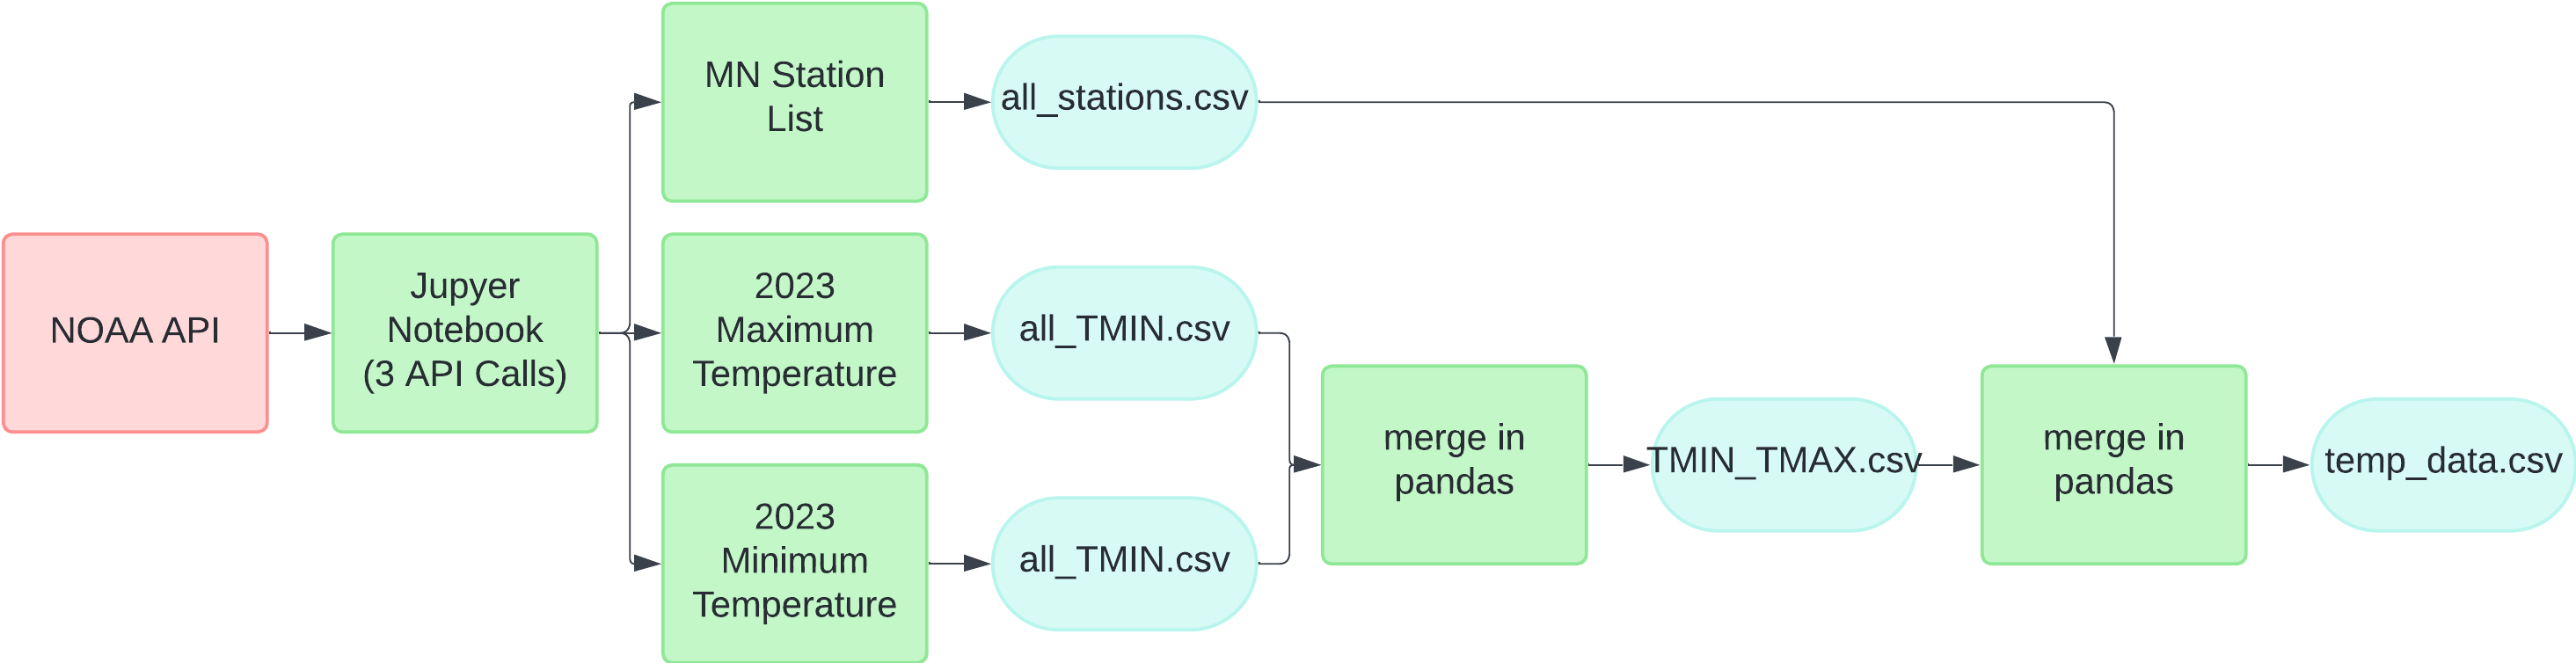

In [2]:
#imports
import csv
import requests
from collections import deque
import os
import time
import pandas as pd
from datetime import timedelta

In [4]:
# Set the working directory to the ArcGIS Project directory and configure the environment
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
arcpy.env.workspace = os.path.join(file_path, 'MN_Geo_Data')

# Read the API key from a file and remove any leading/trailing whitespace.
with open('./API_Keys/NOAA_Token.txt', 'r') as file:
    api_key = file.read().strip()

# Base URL for the API calls.
url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/'

# Headers required for the API call, including the authorization token.
headers = {
    'token': api_key  # API key is passed as a token in the header.
}

def api_call(url, endpoint, headers, parameters):
    """
    Make an API call to the specified URL and endpoint with given headers and parameters.
    
    Args:
        url (str): The base URL for the API.
        endpoint (str): The specific endpoint to access data from the API.
        headers (dict): Headers to include in the request (e.g., authorization tokens).
        parameters (dict): Query parameters to customize the request.
    
    Returns:
        dict: The JSON response from the API if the call is successful, None otherwise.
    """
    try:
        print(parameters['offset'])  # Debugging: print the current offset before making the call.
        response = requests.get(url + endpoint, headers=headers, params=parameters)  # Perform the GET request.
        response.raise_for_status()  # Check for HTTP errors and raise exceptions for them.
        print("API Called")  # Debugging: confirm the API was called.
        return response.json()  # Return the parsed JSON response.
    except requests.exceptions.RequestException as e:
        print(f"API call failed: {e}")  # Handle exceptions (e.g., network issues, 4xx and 5xx errors).
        return None

def append_to_csv(file_path, data, fieldnames):
    """
    Append data to a CSV file. If the file doesn't exist, create it and write the headers.
    
    Args:
        file_path (str): Path to the CSV file.
        data (list): A list of dictionaries representing the rows to append.
        fieldnames (list): Headers or fieldnames for the CSV.
    """
    with open(file_path, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if file.tell() == 0:  # Check if the file is empty to decide if headers need to be written.
            writer.writeheader()
        writer.writerows(data)  # Append the data rows to the CSV file.

def append_metadata_to_csv(metadata_file_path, metadata):
    """
    Append metadata to a CSV file.
    
    Args:
        metadata_file_path (str): Path to the CSV file where metadata is stored.
        metadata (dict): Metadata to be appended.
    """
    with open(metadata_file_path, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metadata['resultset'].keys())
        if file.tell() == 0:  # Check if the file is empty to decide if headers need to be written.
            writer.writeheader()
        writer.writerow(metadata['resultset'])  # Append metadata to the metadata CSV.
        
def execute_api_calls_with_retries(base_url, endpoint, headers, initial_parameters, file_path, metadata_file_path, error_log_path, max_retries=3):
    """
    Execute API calls with a mechanism for retries on failure, appending successful results to a CSV file
    and metadata to another CSV file.
    
    Args:
        base_url (str): The base URL for the API calls.
        endpoint (str): The specific endpoint to access data from the API.
        headers (dict): Headers to include in the request.
        initial_parameters (dict): Initial query parameters for the API call.
        file_path (str): Path to the CSV file where results are stored.
        metadata_file_path (str): Path to the CSV file where metadata is stored.
        error_log_path (str): Path to the CSV file where failed attempts are logged.
        max_retries (int): Maximum number of retry attempts for a failed API call.
    """
    if os.path.exists(file_path):
        print(f"CSV file {file_path} already exists. Operation cancelled to prevent overwriting.")
        return  # Prevents overwriting existing data by aborting if the file already exists.
    
    stack = deque([initial_parameters])  # Use a stack to manage API call parameters, starting with the initial parameters.
    failed_attempts = []  # Track parameters that fail to succeed after the maximum number of retries.
    
    while stack:
        parameters = stack.pop()  # Pop the last set of parameters to make an API call.
        retries = parameters.pop('retries', 0)  # Extract or initialize the retry counter for these parameters.
        data = api_call(base_url, endpoint, headers, parameters)  # Attempt the API call.
        
        if data and 'results' in data:  # Check if the call was successful and data was returned.
            append_to_csv(file_path, data['results'], data['results'][0].keys())  # Append successful results to the CSV.
            append_metadata_to_csv(metadata_file_path, data['metadata'])  # Append metadata to the metadata CSV
            
            # Check if there are more results to fetch and prepare the next set of parameters.
            if parameters.get('offset', 1) + parameters.get('limit', 10) - 1 < data['metadata']['resultset']['count']:
                next_params = parameters.copy()
                next_params['offset'] += parameters.get('limit', 10)
                stack.append(next_params)  # Add the next parameters to the stack for subsequent API calls.
        else:
            # Retry logic for failed attempts.
            if retries < max_retries:
                parameters['retries'] = retries + 1  # Increment the retry counter.
                stack.append(parameters)  # Re-add the parameters to the stack for retry.
            else:
                failed_attempts.append(parameters)  # Log parameters that exceeded max retries.
                
    # After all attempts, log any parameters that failed to succeed after max retries to a file.
    if failed_attempts:
        with open(error_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(failed_attempts)  # Log failed attempts for further investigation.

In [62]:
# Example of how to call the function
endpoint = "/stations/"
parameters = {
    "locationid": "FIPS:27",
    "limit": 1000,
    "offset": 1
}
file_path = "all_stations.csv"
error_log_path = "error_log.csv"
metadata_path = "stations_meta.csv"

#Run API calls to download station data
execute_api_calls_with_retries(url, endpoint, headers, parameters, file_path, metadata_path, error_log_path, max_retries=3)

CSV file all_stations.csv already exists. Operation cancelled to prevent overwriting.


In [63]:
#Test downloading data from all stations
endpoint = '/data/'

# Specify the dataset, station ID, and date range
parameters = {
    'datasetid': 'GHCND',
    'locationid': 'FIPS:27',
    'datatypeid': 'TMAX',
    'limit': 1000, # max is 1000 for a single request
    'offset': 1,
    'units': 'metric',
    'startdate': '2023-01-01',
    'enddate': '2023-12-31'
}

file_path = "all_TMAX.csv"
error_log_path = "error_log.csv"
metadata_path = "stations_meta.csv"

#Run API calls to download TMAX data
execute_api_calls_with_retries(url, endpoint, headers, parameters, file_path, metadata_path, error_log_path, max_retries=3)

1
API Called
CSV file all_TMAX.csv already exists. Operation cancelled to prevent overwriting.


In [64]:
#Test downloading data from all stations
endpoint = '/data/'

# Specify the dataset, station ID, and date range
parameters = {
    'datasetid': 'GHCND',
    'locationid': 'FIPS:27',
    'datatypeid': 'TMIN',
    'limit': 1000, # max is 1000 for a single request
    'offset': 1,
    'units': 'metric',
    'startdate': '2023-01-01',
    'enddate': '2023-12-31'
}

file_path = "all_TMIN.csv"
error_log_path = "error_log.csv"
metadata_path = "stations_meta.csv"

#Run API calls to download TMIN data
execute_api_calls_with_retries(url, endpoint, headers, parameters, file_path, metadata_path, error_log_path, max_retries=3)

1
API Called
CSV file all_TMIN.csv already exists. Operation cancelled to prevent overwriting.


In [71]:
#Data CLEANING
tmin_df = pd.read_csv('all_TMIN.csv')
tmax_df = pd.read_csv('all_TMAX.csv')

# Merge TMAX and TMIN on 'date' and 'station'
merged_temp_df = pd.merge(tmax_df[['date', 'station', 'value']], tmin_df[['date', 'station', 'value']], on=['date', 'station'], suffixes=('_TMAX', '_TMIN'))

In [72]:
merged_temp_df

,date,station,value_TMAX,value_TMIN
0,2023-01-01T00:00:00,GHCND:CA006020559,-4.0,-6.0
1,2023-01-01T00:00:00,GHCND:USC00210018,-4.4,-9.4
2,2023-01-01T00:00:00,GHCND:USC00210050,-5.6,-8.3
3,2023-01-01T00:00:00,GHCND:USC00210075,1.1,-5.0
4,2023-01-01T00:00:00,GHCND:USC00210190,1.7,-6.1
...,...,...,...,...
63639,2023-12-31T00:00:00,GHCND:USW00094961,-3.8,-7.7
63640,2023-12-31T00:00:00,GHCND:USW00094963,-1.6,-4.9
63641,2023-12-31T00:00:00,GHCND:USW00094967,-5.5,-7.7
63642,2023-12-31T00:00:00,GHCND:USW00094976,-4.3,-7.7


In [73]:
merged_temp_df.to_csv('TMIN_TMAX.csv')

In [74]:
tmin_tmax_df = pd.read_csv('TMIN_TMAX.csv')
stations_df = pd.read_csv('all_stations.csv')

# Perform the merge again without extracting the station ID, using the full 'station' value from TMIN_TMAX DataFrame
# This time, we directly compare the 'station' field in TMIN_TMAX with the 'id' field in the Stations DataFrame
merged_df_correct = pd.merge(tmin_tmax_df, stations_df, left_on='station', right_on='id', how='left')

# Select relevant columns, including latitude and longitude from the Stations DataFrame
merged_df = merged_df_correct[['date', 'station', 'value_TMAX', 'value_TMIN', 'latitude', 'longitude']]

In [75]:
merged_df.to_csv('temp_data.csv', index = False)

## Temperature QAQC

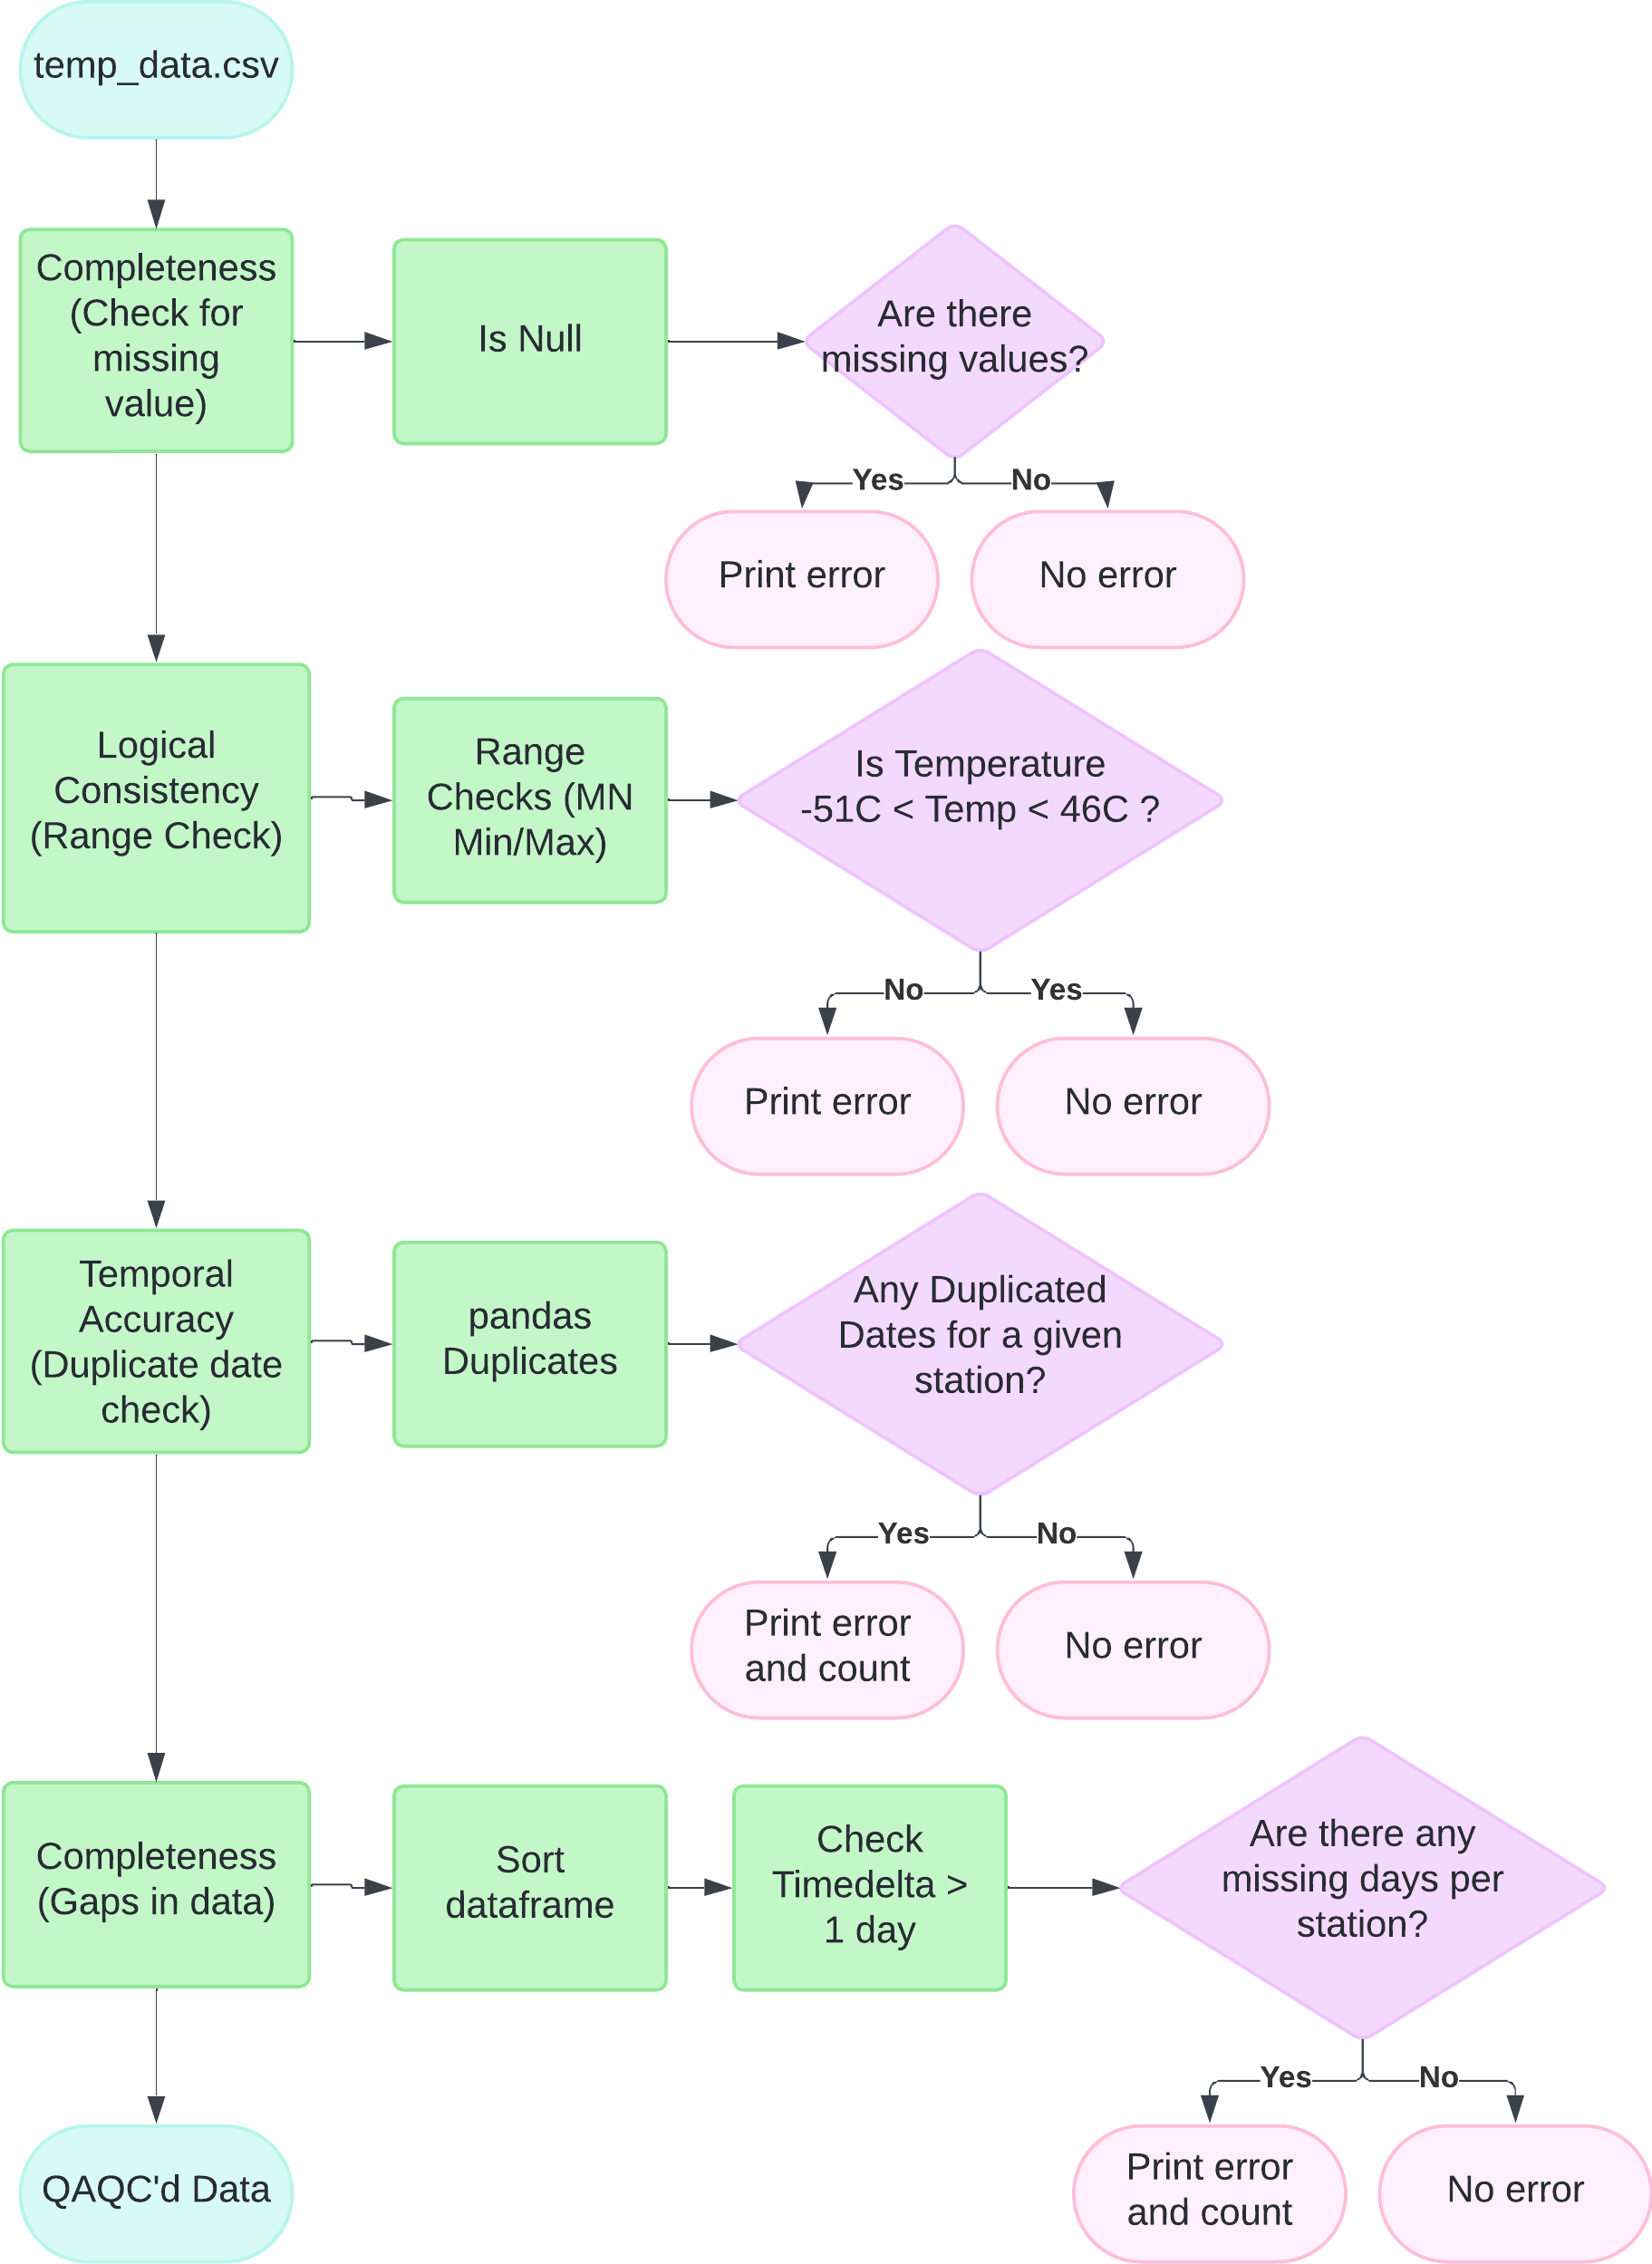

In [5]:
# Load the dataset
df = pd.read_csv('temp_data.csv')

# Convert date column to datetime for easier manipulation
df['date'] = pd.to_datetime(df['date'])

# 1. Missing Values Check
missing_values_check = df[['value_TMAX', 'value_TMIN']].isnull().sum()

# 2. Logical Consistency Check (TMIN should not be greater than TMAX)
logical_inconsistency_check = df[df['value_TMIN'] > df['value_TMAX']].shape[0]

# 3. Temperature Range Outliers Check
# Assuming typical extreme temperature ranges for Minnesota: -51°C to 46°C
temperature_outliers_check = {
    'TMAX_below_typical_min': df[df['value_TMAX'] < -51].shape[0],
    'TMAX_above_typical_max': df[df['value_TMAX'] > 46].shape[0],
    'TMIN_below_typical_min': df[df['value_TMIN'] < -51].shape[0],
    'TMIN_above_typical_max': df[df['value_TMIN'] > 46].shape[0]
}

# 4. Duplicate Dates Check
duplicate_dates_check = df.duplicated(subset=['station', 'date']).sum()

# 5. Potential Gaps in Data
df_sorted = df.sort_values(by=['station', 'date'])
df_sorted['next_date'] = df_sorted.groupby('station')['date'].shift(-1)
df_sorted['date_diff'] = df_sorted['next_date'] - df_sorted['date']
gaps_check = df_sorted[df_sorted['date_diff'] > timedelta(days=1)].shape[0]

# Print results (or further analyze, depending on your needs)
print("Missing Values Check:\n", missing_values_check)
print("\nLogical Inconsistency Check:\n", logical_inconsistency_check)
print("\nTemperature Outliers Check:\n", temperature_outliers_check)
print("\nDuplicate Dates Check:\n", duplicate_dates_check)
print("\nPotential Gaps in Data Check:\n", gaps_check)

Missing Values Check:
 value_TMAX    0
value_TMIN    0
dtype: int64

Logical Inconsistency Check:
 0

Temperature Outliers Check:
 {'TMAX_below_typical_min': 0, 'TMAX_above_typical_max': 0, 'TMIN_below_typical_min': 0, 'TMIN_above_typical_max': 0}

Duplicate Dates Check:
 0

Potential Gaps in Data Check:
 751
